# Quick start on mock simulations using `meer21cm`

In this notebook, we give a brief overview of using `meer21cm` to generate mock simulations of HI temperature field and galaxy sample, and show how to use the field and galaxy sample for power spectrum estimation.

`meer21cm` has two key features:
1. The package is easy to interact. A lot of the functionalities are wrapped under the hood.
2. A smart cache system is used, so that computationally heavy functions are only run once. However, if the relevant parameters are updated, the cache is automatically cleared so that it can be updated.

In [1]:
from meer21cm import MockSimulation
import numpy as np
import matplotlib.pyplot as plt
from meer21cm.plot import plot_map
import time

/Users/zhaotingchen/miniconda3/envs/pmesh/lib/python3.10/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import NoExclusion


## Generation of mock signal maps:

In order to generate a mock signal and use it for power spectrum estimation, three steps must be performed:

1. Based on the survey area and redshift range of choice, generate a regular grid box with **relatively fine** resolution. Use the parameters to generate either a density field or a discrete source catalogue in the box.
2. Project the generated tracer onto the sky in (RA,Dec,z). For density field, it is averaged onto the map-level pixels. Noise, foregrounds, beam and other effects can be then added.
3. Use the map or the source catalogue, and grid the data into a regular grid box with **relatively coarse** reolustion. Perform power spectrum estimation.

Note that, each of the step has many nuances and examples to discuss these steps in details are being prepared. For now, let us just go through the whole thing without exhausting all the details.

We can construct a mock simulation by simply:

In [11]:
# fixing seed for reproducable results
mock = MockSimulation(seed=42)

Note: redshifts have been re-sorted (earliest first)
no input beam found, setting include_beam to False
Note: redshifts have been re-sorted (earliest first)
no input beam found, setting include_beam to False


/Users/zhaotingchen/miniconda3/envs/pmesh/lib/python3.10/site-packages/numpy/fft/helper.py:162: RuntimeWarning: divide by zero encountered in scalar divide
  val = 1.0 / (n * d)
/Users/zhaotingchen/miniconda3/envs/pmesh/lib/python3.10/site-packages/numpy/fft/helper.py:169: RuntimeWarning: invalid value encountered in multiply
  return results * val


The mock object contains all sorts of configurations and settings for the simulations, and the default corresponds to the MeerKLASS L-band deep-field. For example, the frequency range and resolution are:

In [12]:
# in Hz
mock.nu.min(),mock.nu.max(),np.diff(mock.nu).mean()

(971150390.625, 1023605468.75, 208984.375)

You can always update attributes of `mock` on the fly. For example, now I want to limit my survey area:

In [13]:
raminMK,ramaxMK = 334,357
decminMK,decmaxMK = -35,-26.5
ra_range = (raminMK,ramaxMK)
dec_range = (decminMK,decmaxMK)

In [14]:
mock.ra_range = ra_range
mock.dec_range = dec_range
mock.trim_map_to_range()

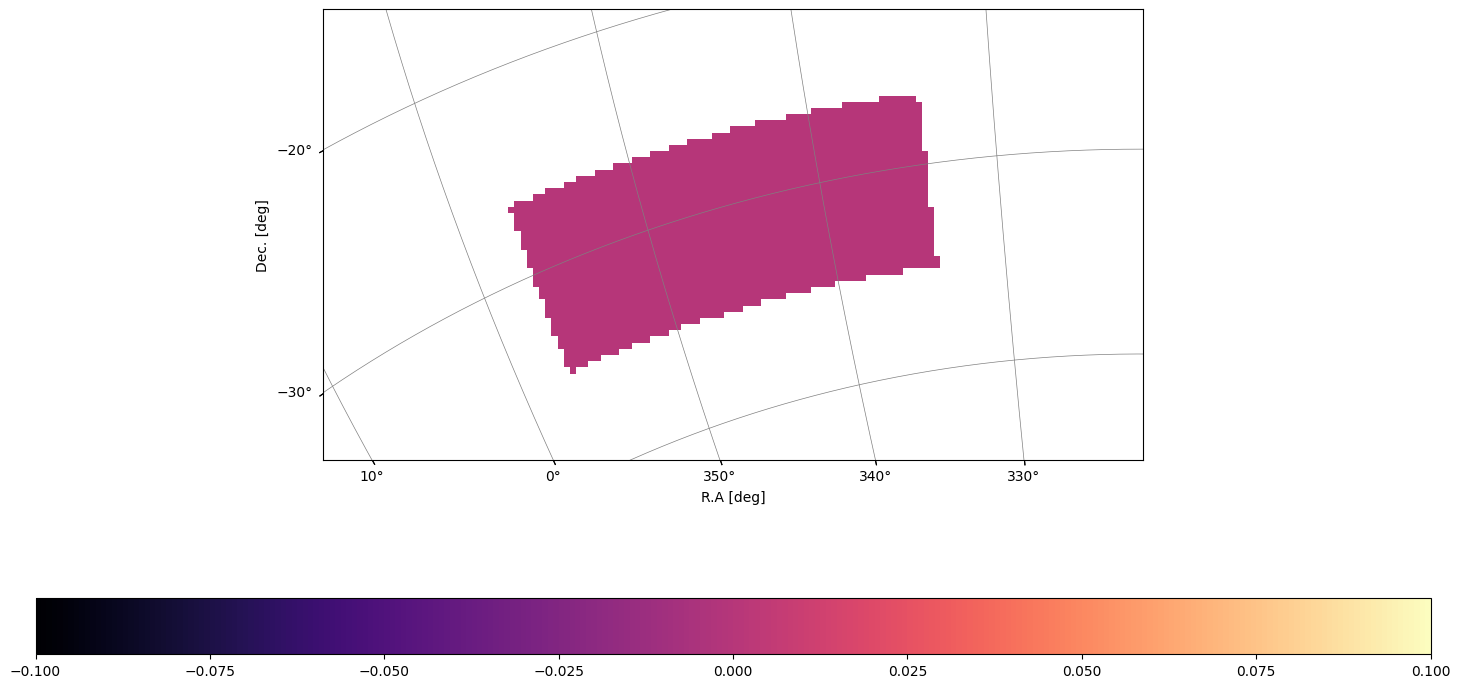

In [15]:
plot_map(mock.data,mock.wproj,W=mock.W_HI)

Here, `W_HI` is the binary window where 1 suggests that the pixels are sampled. `wproj` is an `astropy` WCS object for storing the survey area.

Now we can simply generate a mock signal map of HI overdensity:

In [16]:
# this is to tell mock to use **relatively fine** grid
mock.downres_factor_radial = 1/2.0
mock.downres_factor_transverse = 1/2.0
mock_map = mock.grid_field_to_sky_map(mock.mock_tracer_field_1)
# pass the mock map as the data
mock.data = mock_map[0]

Note: redshifts have been re-sorted (earliest first)


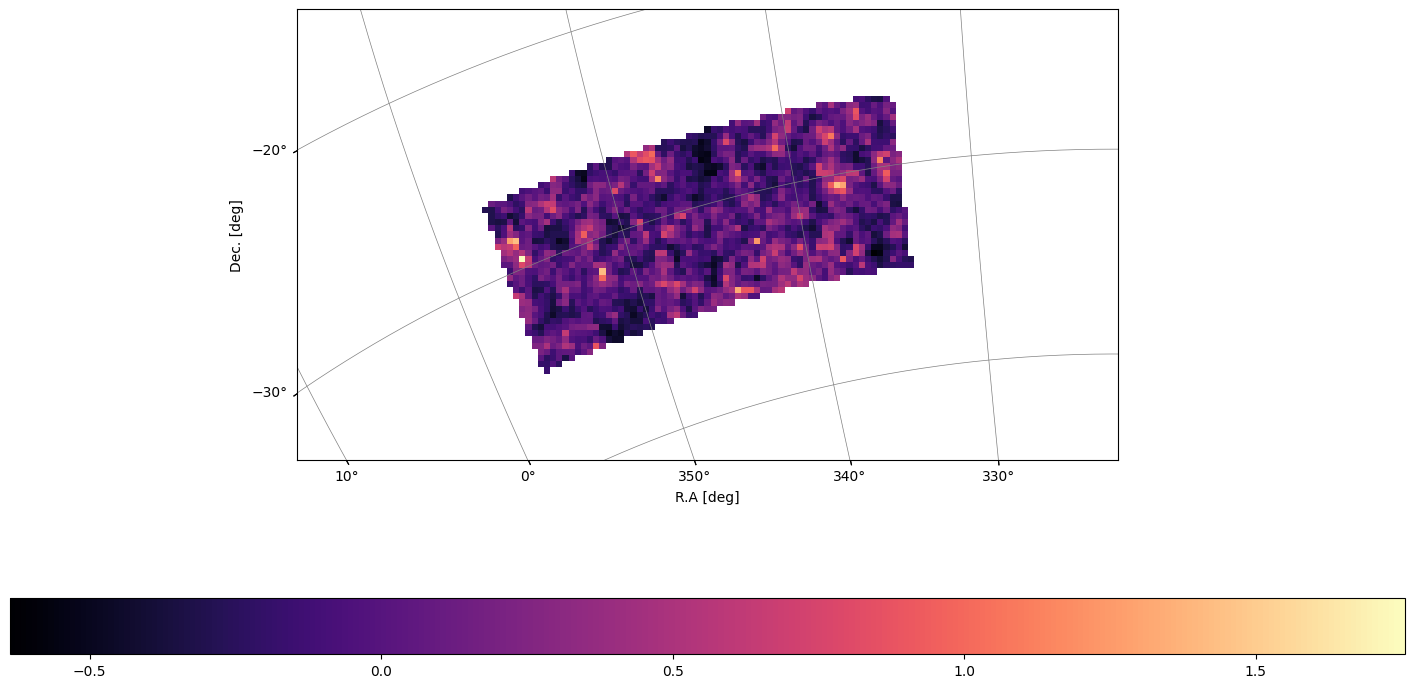

In [21]:
plot_map(mock.data,mock.wproj,W=mock.W_HI)

Note that, here I have already asked `mock` to do three different things under the hood:

- Calculate box dimensions for the density simulation
- Simulate a lognormal realization of the tracer density
- Project the tracer density field onto the map

While this is all done behine the scenes, you can also asked for it to be done separately:

In [23]:
# calculate box dimensions
mock.get_enclosing_box()
# generate tracer field
mock.get_mock_tracer_field_1()
# then grid
mock.data = mock.grid_field_to_sky_map(mock.mock_tracer_field_1)[0]

Note that here, I choose the first tracer `mock.mock_tracer_field_1` to grid onto the sky. When it is invoked, `mock.mock_tracer_field_1` automatically gets calculated under the hood. When you want to use it again, it is already cached:

In [24]:
s_t = time.time()
mock.mock_tracer_field_1
print(time.time()-s_t)

0.006798982620239258


But if you modify related quantities, for example the underlying cosmology, it will be updated automatically:

In [25]:
print('Cosmology was:', mock.cosmo)
mock.cosmo = 'WMAP1'
print('Cosmology now:', mock.cosmo)
s_t = time.time()
mock.mock_tracer_field_1
print(time.time()-s_t)

Cosmology was: w0waCDM(name="new", H0=67.66 km / (Mpc s), Om0=0.30966, Ode0=0.6888523996875395, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.04897, w0=-1.0, wa=0.0)
Cosmology now: w0waCDM(name="WMAP1", H0=72.0 km / (Mpc s), Om0=0.257, Ode0=0.7429194200190258, Tcmb0=2.725 K, Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=0.0436, w0=-1.0, wa=0.0)
Note: redshifts have been re-sorted (earliest first)
2.0079522132873535


Note that here the original 'new' cosmology corresponds to Planck18. Note that, `meer21cm` assumes w0waCDM, and the input parameter set for the cosmology is:

In [26]:
pars_set = {
    "omega_cold":mock.omega_cold, # CDM + Baryon, i.e. Om0
    "As":mock.As, # as in standard CMB definition
    "omega_baryon":mock.omega_baryon, # Ob0
    "ns":mock.ns, # as in standard CMB definition
    "h":mock.h, # hubble 
    "neutrino_mass":mock.neutrino_mass, # in eV, assumes [0,0,m_nu]
    "w0":mock.w0, # dark energy eos
    "wa":mock.wa, # dark energy eos
}
print(pars_set)

{'omega_cold': 0.257, 'As': 1.893e-09, 'omega_baryon': 0.0436, 'ns': 0.96, 'h': 0.72, 'neutrino_mass': 0.0, 'w0': -1.0, 'wa': 0.0}


You can also manually set any of the above parameters:

In [27]:
mock.h = 0.7
mock.omega_cold = 0.25
mock.omega_baryon = 0.02
mock.neutrino_mass = 0.01
mock.w0=-0.95
mock.wa=-0.05

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


In [28]:
s_t = time.time()
mock.mock_tracer_field_1
print(time.time()-s_t)

Note: redshifts have been re-sorted (earliest first)
5.235108137130737


In [29]:
mock_map = mock.grid_field_to_sky_map(mock.mock_tracer_field_1)[0]
# pass the mock map as the data
mock.data = mock_map

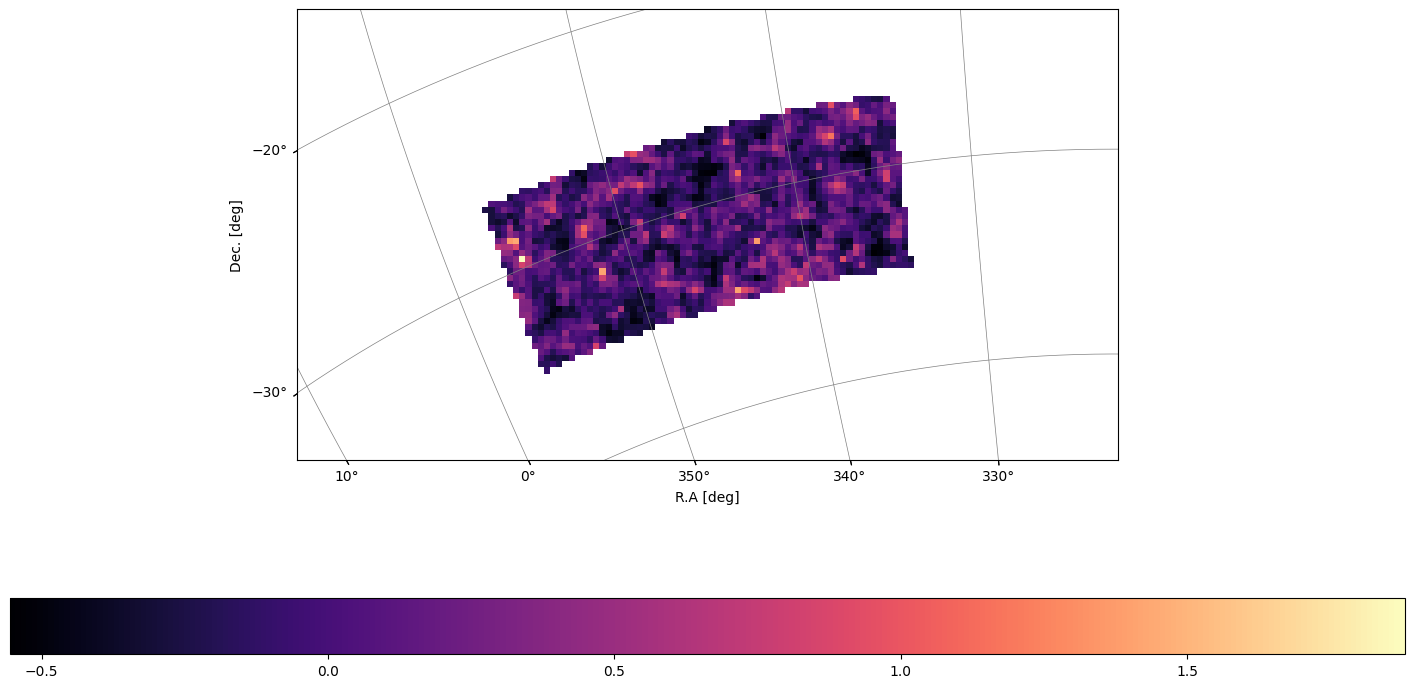

In [30]:
plot_map(mock.data,mock.wproj,W=mock.W_HI)

Note the small difference in colour bar, you can see indeed it has been updated. If you change irrelevant quantity, for example the bias for tracer 2, it does not clear the cache:

In [31]:
# change tracer 2
mock.tracer_bias_2 = 1.0
# still use tracer 1
mock_map = mock.grid_field_to_sky_map(mock.mock_tracer_field_1)[0]
# pass the mock map as the data
mock.data = mock_map

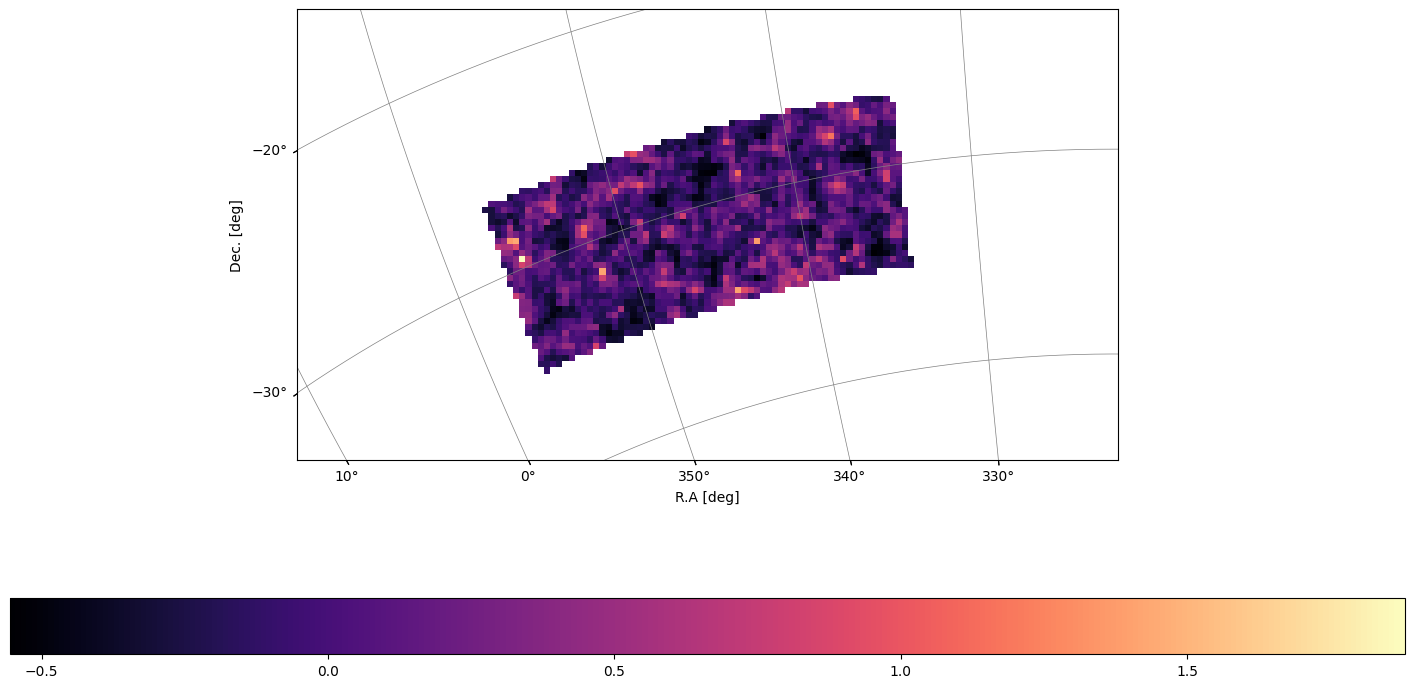

In [32]:
plot_map(mock.data,mock.wproj,W=mock.W_HI)

The overdensity by default does not have unit. However, you can specify a number, or even a function as the mean amplitude `mock.mean_amp_1`. Currently, HI temperature is supported:

In [33]:
mock.omegahi = 5.4e-4
# in Kelvin
print(mock.average_hi_temp) 
# you can simply tell mock to use this as the amplitude
mock.mean_amp_1 = 'average_hi_temp'

0.00011793285032756018


Again, the stored overdensity will be multiplied by the amplitude automatically. Just regrid it onto the sky:

In [34]:
mock_map = mock.grid_field_to_sky_map(mock.mock_tracer_field_1)[0]
# pass the mock map as the data
mock.data = mock_map

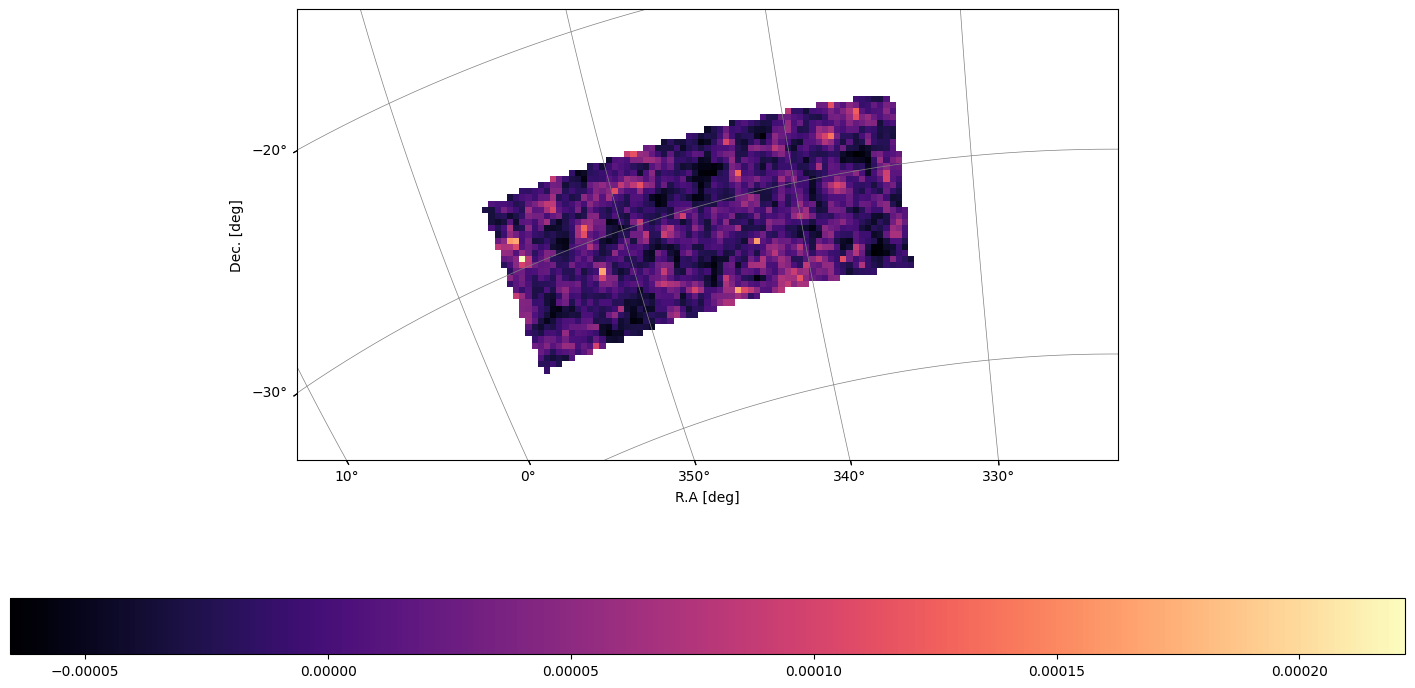

In [35]:
plot_map(mock.data,mock.wproj,W=mock.W_HI)

Now your map is in Kelvin unit.

## Generate of mock galaxy catalogues

We may also want to generate some mock galaxies for cross-correlation. It is again done almost automatically:

In [36]:
# base the galaxy catalogue on tracer 2
mock.discrete_base_field = 2
# specify galaxy bias
mock.tracer_bias_2 = 1.0
# specify how many galaxies you want
mock.num_discrete_source = 30000
mock.propagate_mock_tracer_to_gal_cat()

/Users/zhaotingchen/Desktop/work/meer21cm/src/meer21cm/mock.py:381: UserWarning: Not enough tracers inside the ra, dec, z range. Try increasing target_relative_to_num_g.
  warnings.warn(


Once again, many things are done under the hood. 

First, a discrete sample of tracers are generated in the box. 

In [37]:
mock.get_mock_tracer_position_in_box(mock.discrete_base_field)

Then, it is rotated back to (RA,Dec,z) coordinates. 

Note that the number of source positions generated will be larger than `mock.num_discrete_source`. This is because the box will be larger than the survey lightcone to ensure the lightcone will be fully covered.

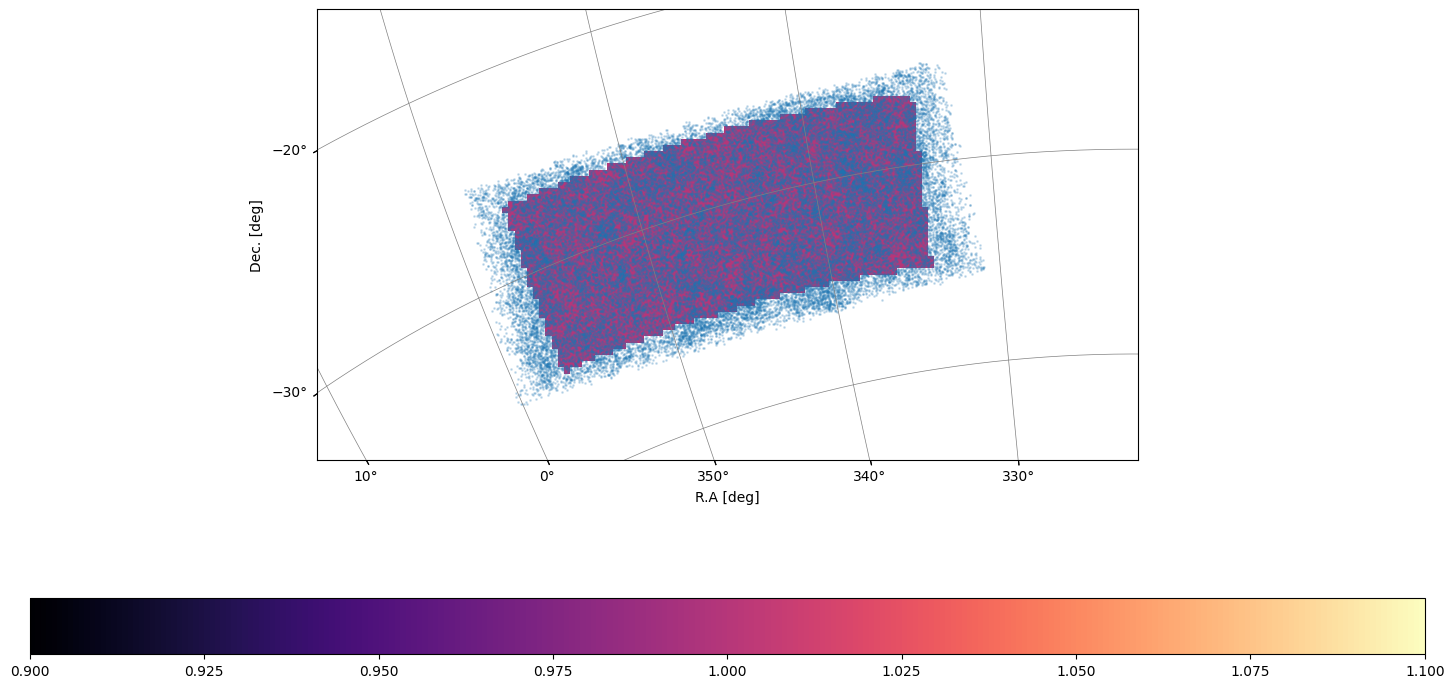

In [38]:
plot_map(mock.W_HI,mock.wproj,W=mock.W_HI)
ax = plt.gca()
plt.scatter(
    mock.ra_mock_tracer,
    mock.dec_mock_tracer,
    transform=ax.get_transform('world'),s=1,label='mock tracers',alpha=0.2
)

And finally, excess sources will be excluded and the rest stored as the galaxy catalogue:

In [39]:
mock.propagate_mock_tracer_to_gal_cat()


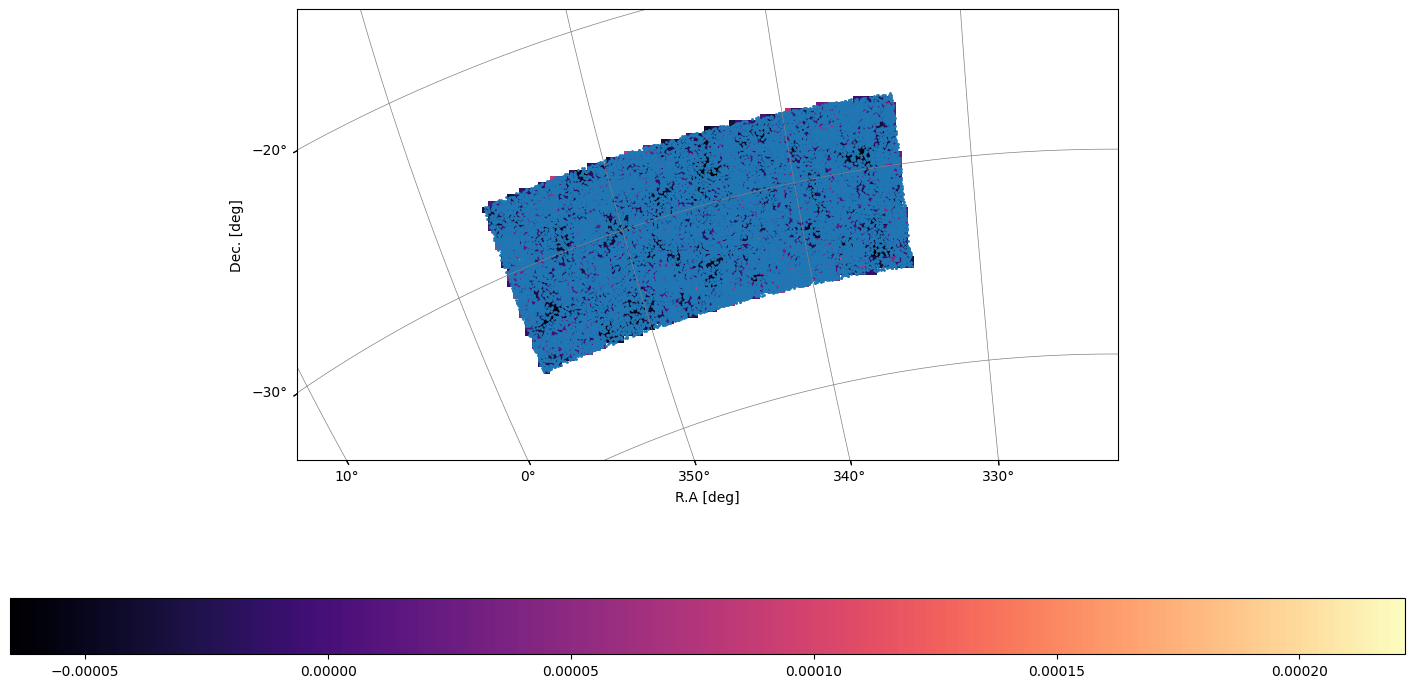

In [40]:
plot_map(mock.data,mock.wproj,W=mock.W_HI)
ax = plt.gca()
plt.scatter(
    mock.ra_gal,
    mock.dec_gal,
    transform=ax.get_transform('world'),s=1,label='mock gals'
)

You can then use the signal map and the galaxy catalogue for power spectrum estimation, and compare it with model power spectrum.

In [41]:
# internal parameter for compensating gridding effects
# will have more description in another tutorial
mock.compensate= True
# this is to tell mock to use **relatively coarse** resolution
mock.downres_factor_radial = 1.5
mock.downres_factor_transverse = 1.2
# this is used for shot noise calculation later
_,_,pixel_counts_hi_rg = mock.grid_data_to_field()
# project the galaxy number density to a regular grid
mock.grid_gal_to_field()

/Users/zhaotingchen/Desktop/work/meer21cm/src/meer21cm/grid.py:412: RuntimeWarning: invalid value encountered in divide
  mesh_mass = np.where(mesh_weights > 0, mesh_mass / mesh_weights, 0)


no input beam found, setting include_beam to False


(array([[[ 8.86814090e-18, -2.25540699e-17, -1.06780091e-16, ...,
          -3.36655600e-17, -7.32581718e-17, -8.61812488e-17],
         [-1.49699452e-17,  1.51058975e-17, -2.89995875e-17, ...,
           6.05112105e-17, -1.14135500e-17, -4.72381756e-17],
         [ 5.03466721e-18,  2.13794013e-17, -4.80225309e-17, ...,
          -2.47192507e-17,  6.49113857e-17, -4.64570543e-17],
         ...,
         [ 4.02765943e-18, -4.57886233e-17, -1.07782450e-17, ...,
          -3.83783418e-17,  3.38676262e-17,  1.21224476e-17],
         [ 2.85097405e-17, -5.82314286e-17,  1.05424310e-16, ...,
           2.72177901e-17, -1.81633771e-17,  3.32788076e-17],
         [ 3.19415544e-17,  3.04744743e-17, -8.08798871e-17, ...,
          -1.80075544e-17, -1.62843941e-17, -2.90782673e-18]],
 
        [[-3.67352386e-17, -5.89828805e-18,  5.41346095e-17, ...,
           3.19388595e-17, -6.61197484e-17,  3.05341843e-18],
         [ 7.71793852e-17, -3.82588211e-17,  2.33953897e-17, ...,
          -3.84873522

By default, sky map is stored as field 1 and galaxy catalogue is stored as field 2. You can retrieve both the field-level power spectrum and the model power very easily:

In [42]:
shot_noise_g = mock.survey_volume/mock.ra_gal.size
# 1d k-bins in Mpc-1
k1dedges = np.geomspace(0.05, 0.5, 11)
# pass it to mock
mock.k1dbins = k1dedges
# get model
pmod_1d_gg,_,_ = mock.get_1d_power(
    'auto_power_tracer_2_model'
)
pmod_1d_hi,_,_ = mock.get_1d_power(
    'auto_power_tracer_1_model'
)
pmod_1d_cross,_,_ = mock.get_1d_power(
    'cross_power_tracer_model'
)
# get data
pdata_1d_gg,keff,nmodes = mock.get_1d_power(
    'auto_power_3d_2',
)
pdata_1d_hi,keff_hi,nmodes_hi = mock.get_1d_power(
    'auto_power_3d_1',
)
pdata_1d_c,keff_c,nmodes_c = mock.get_1d_power(
    'cross_power_3d',
)


# a naive error bar
perror_1d_gg = (pdata_1d_gg)/np.sqrt(nmodes)
perror_1d_hi = (pdata_1d_hi)/np.sqrt(nmodes_hi)
perror_1d_cross = np.sqrt(pdata_1d_c**2 + pdata_1d_gg*pdata_1d_hi)/np.sqrt(nmodes_c)



Text(0.5, 0, '$\\rm k\\,[Mpc^{-1}]$')

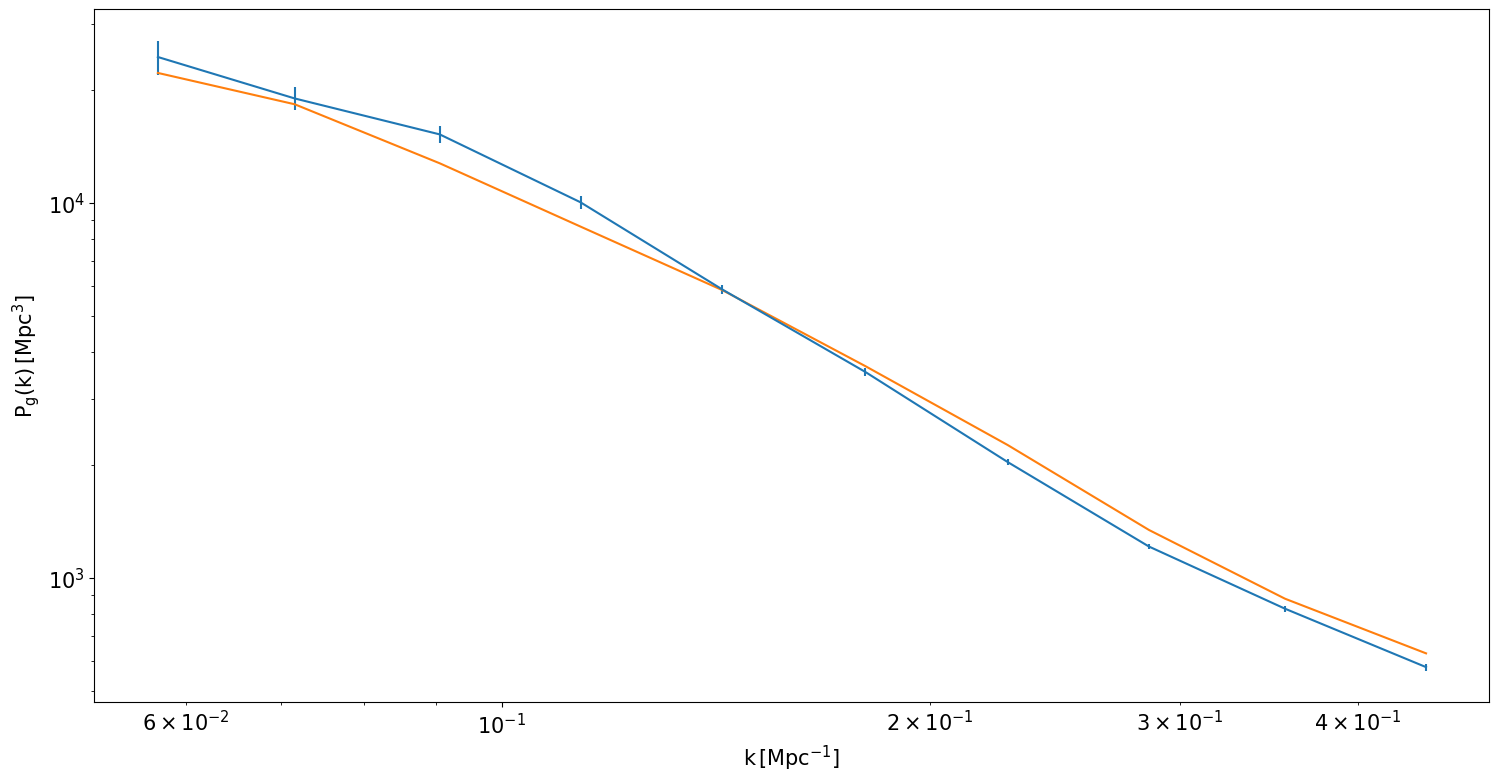

In [43]:
plt.rcParams.update({'font.size':15})
plt.errorbar(keff,pdata_1d_gg-shot_noise_g,yerr=perror_1d_gg)

plt.plot(keff,pmod_1d_gg)

plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\rm P_g(k)\,[Mpc^3]$')
plt.xlabel(r'$\rm k\,[Mpc^{-1}]$')

Text(0.5, 0, '$\\rm k\\,[Mpc^{-1}]$')

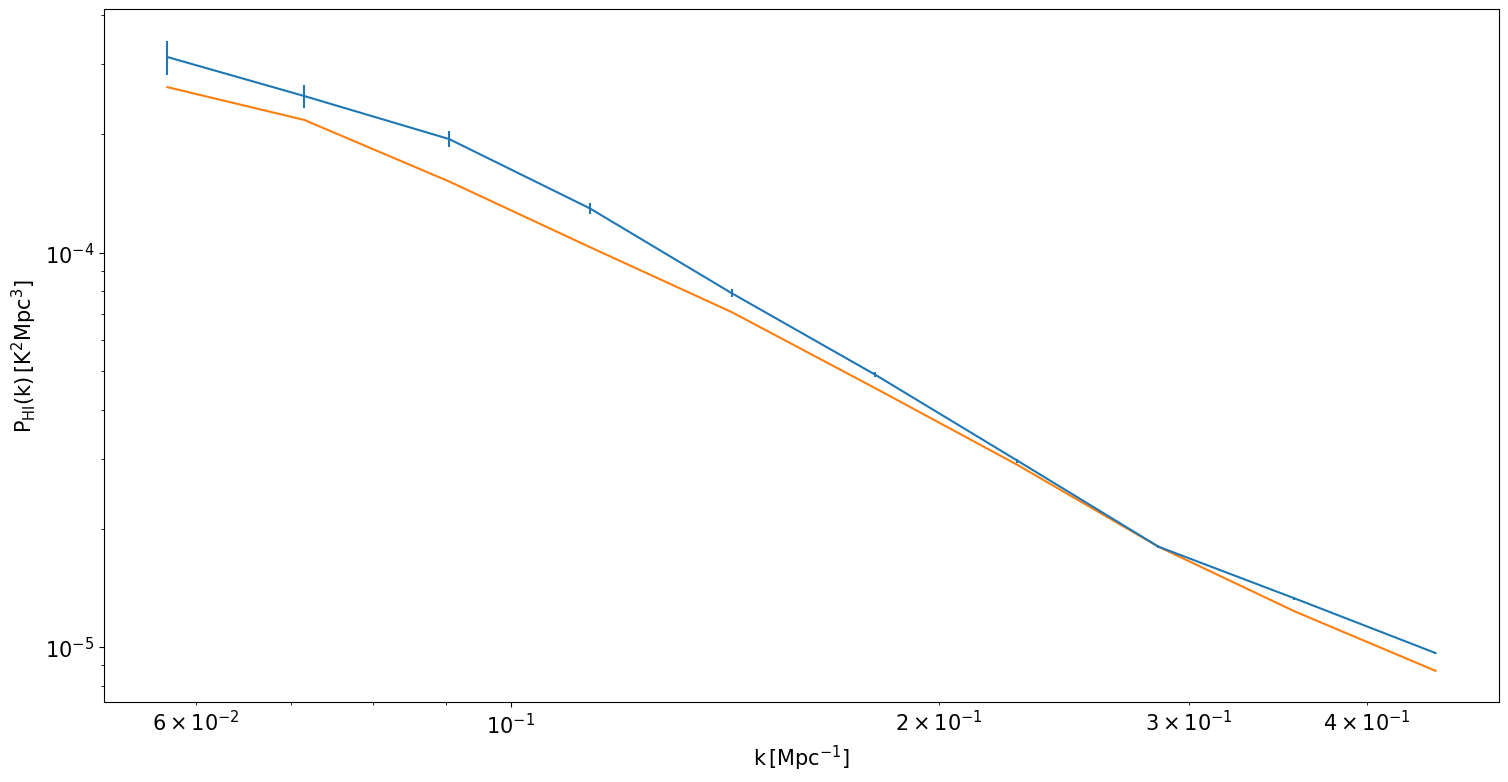

In [44]:
plt.rcParams.update({'font.size':15})
plt.errorbar(keff_hi,pdata_1d_hi,yerr=perror_1d_hi)

plt.plot(keff_hi,pmod_1d_hi)

plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\rm P_{HI}(k)\,[K^2Mpc^3]$')
plt.xlabel(r'$\rm k\,[Mpc^{-1}]$')

Text(0.5, 0, '$\\rm k\\,[Mpc^{-1}]$')

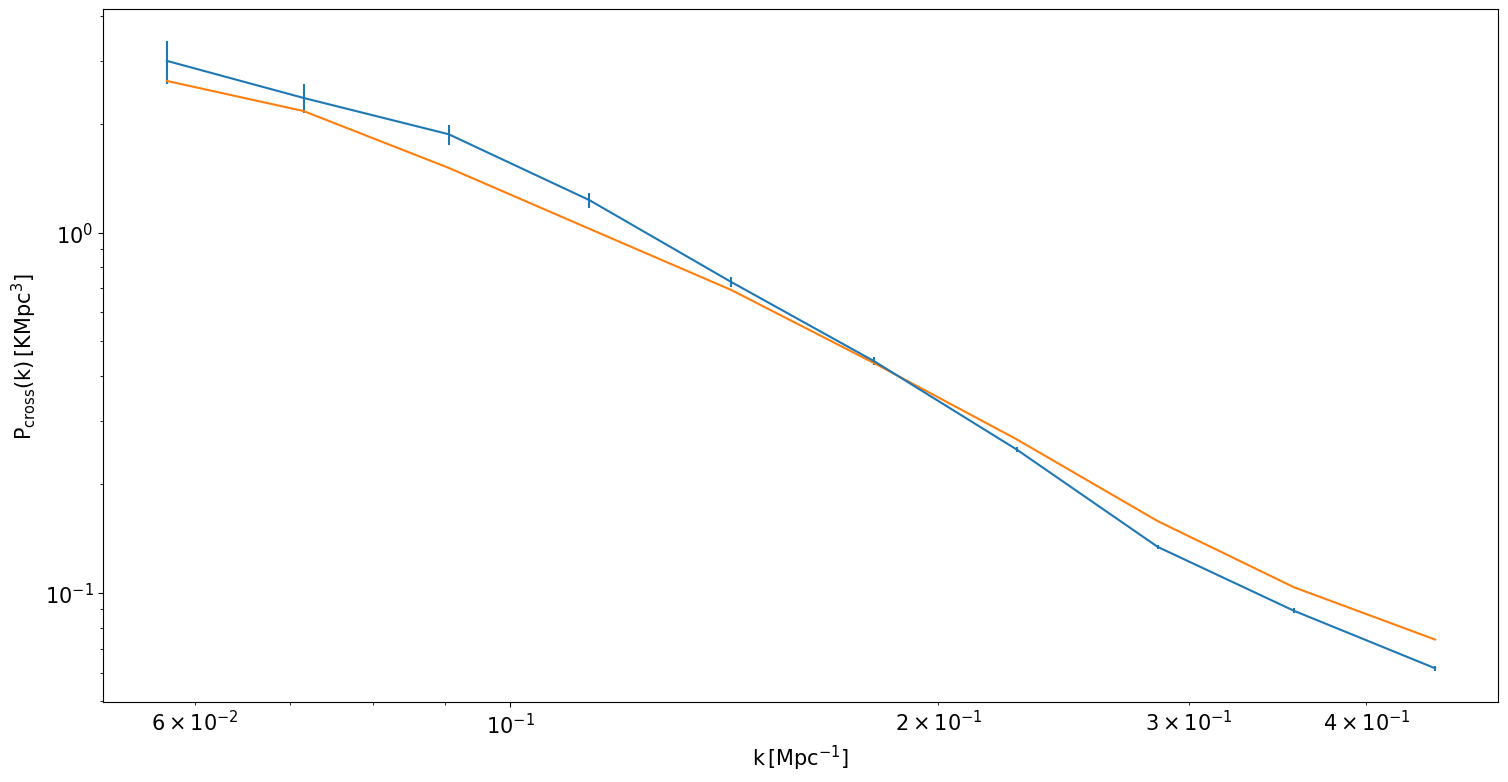

In [45]:
plt.rcParams.update({'font.size':15})
plt.errorbar(keff_c,pdata_1d_c,yerr=perror_1d_cross)

plt.plot(keff,pmod_1d_cross)

plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\rm P_{cross}(k)\,[KMpc^3]$')
plt.xlabel(r'$\rm k\,[Mpc^{-1}]$')

Note that, there is an implicit choice of weighting of the gridded data, which can be manually changed by setting your own `mock.weights_1` and `mock.weights_2`. Also note that, the model power spectrum is automatically set to include all the effects from potentially beam convolution, weights convolution, sampling effects etc. The weighting and impacts on the power spectrum can be found in the dedicated tutorial (TODO).

Internally, `mock` uses a fixed seed number to generate the random fields. If not specified, it will use a random integer from 0 to 2^32:

In [47]:
mock_temp = MockSimulation()
mock_temp.seed

Note: redshifts have been re-sorted (earliest first)
no input beam found, setting include_beam to False
Note: redshifts have been re-sorted (earliest first)
no input beam found, setting include_beam to False


/Users/zhaotingchen/miniconda3/envs/pmesh/lib/python3.10/site-packages/numpy/fft/helper.py:162: RuntimeWarning: divide by zero encountered in scalar divide
  val = 1.0 / (n * d)
/Users/zhaotingchen/miniconda3/envs/pmesh/lib/python3.10/site-packages/numpy/fft/helper.py:169: RuntimeWarning: invalid value encountered in multiply
  return results * val


2217135139

Therefore, you can easily run independent realizations of the signal map for various purposes. Let us run a bunch of signal-only realizations to see if our power spectrum estimation matches the input, and also to calculate the signal covariance:

In [57]:
def run_one_realization(seed=None):
    mock = MockSimulation(
        ra_range=ra_range,dec_range=dec_range,mean_amp_1='average_hi_temp',
        tracer_bias_2=1.0,tracer_bias_1=1.0,
        downres_factor_radial=0.5,downres_factor_transverse=0.5,
        k1dbins = k1dedges,num_discrete_source=30000,compensate=True,
        seed=seed,
    )
    mock.data = mock.grid_field_to_sky_map(mock.mock_tracer_field_1)[0]
    mock.propagate_mock_tracer_to_gal_cat()
    mock.downres_factor_radial=1.5
    mock.downres_factor_transverse=1.2
    mock.grid_data_to_field()
    mock.grid_gal_to_field()
    mock.sampling_resol = np.array([
        mock.pix_resol_in_mpc,
        mock.pix_resol_in_mpc,
        mock.los_resol_in_mpc,
    ])
    mock.compensate = True
    mock.include_sky_sampling = [True, False]
    # get model
    pmod_1d_gg,_,_ = mock.get_1d_power(
        'auto_power_tracer_2_model'
    )
    pmod_1d_hi,_,_ = mock.get_1d_power(
        'auto_power_tracer_1_model'
    )
    pmod_1d_cross,_,_ = mock.get_1d_power(
        'cross_power_tracer_model'
    )
    # get data
    pdata_1d_gg,keff,nmodes = mock.get_1d_power(
        'auto_power_3d_2',
    )
    pdata_1d_hi,keff_hi,nmodes_hi = mock.get_1d_power(
        'auto_power_3d_1',
    )
    pdata_1d_c,keff_c,nmodes_c = mock.get_1d_power(
        'cross_power_3d',
    )
    return [[pmod_1d_gg,pmod_1d_hi,pmod_1d_cross,pdata_1d_gg,pdata_1d_hi,pdata_1d_c],]

    
    
    

In [69]:
%%capture
power_arr = []
s_t = time.time()
for i in range(10):
    power_arr += run_one_realization(i)
t_used = time.time()-s_t

In [70]:
print('Time used in seconds: ',time.time()-s_t)

Time used in seconds:  132.01072001457214


In [71]:
power_arr = np.array(power_arr)

In [72]:
# calculate theoretical shot noise
psn_1d_gg = mock.survey_volume/mock.num_discrete_source

Text(0.5, 0, '$\\rm k\\,[Mpc^{-1}]$')

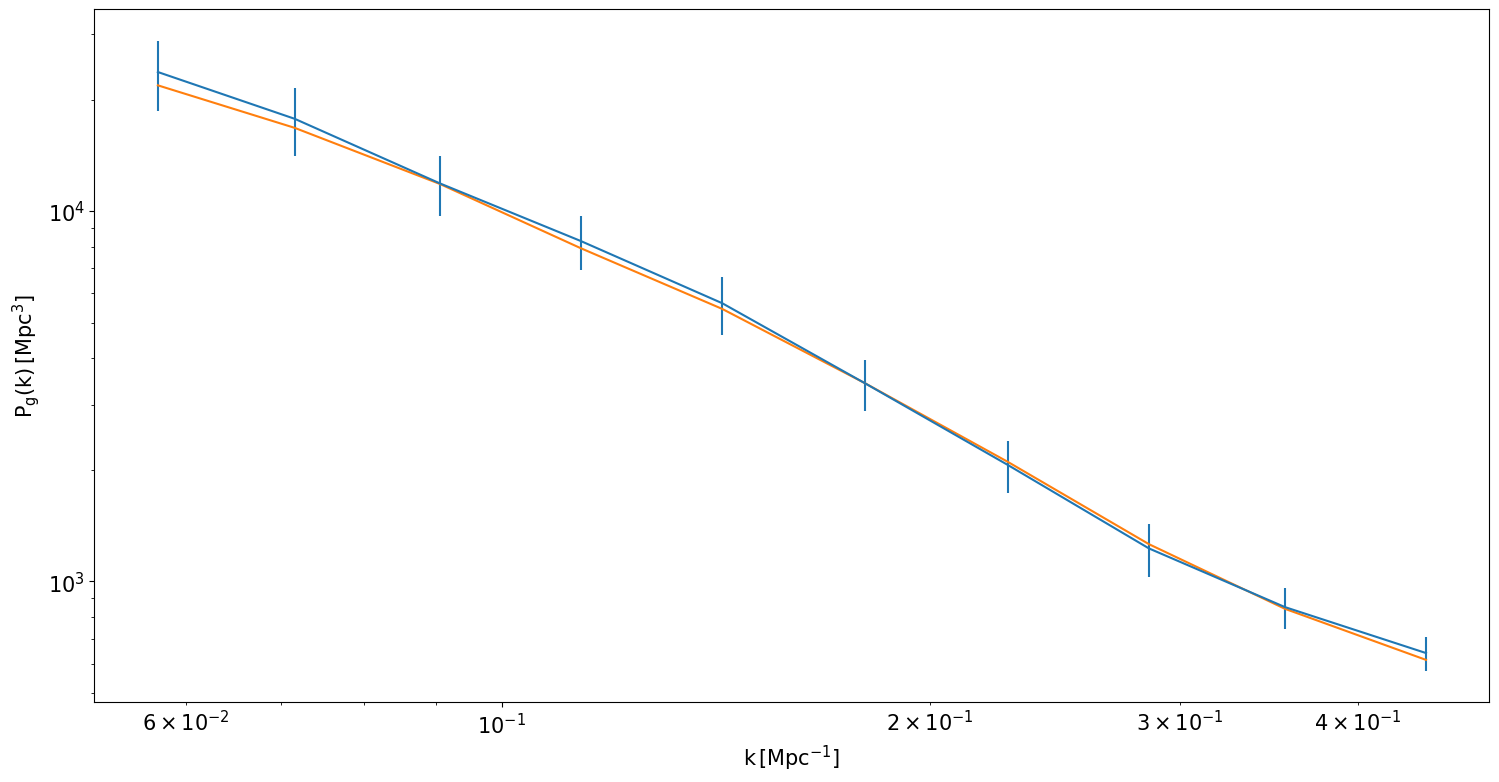

In [73]:
i = 0
plt.rcParams.update({'font.size':15})
plt.errorbar(keff,power_arr.mean(0)[i+3]-psn_1d_gg,yerr=power_arr.std(0)[i+3])

plt.plot(keff,power_arr.mean(0)[i])

plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\rm P_g(k)\,[Mpc^3]$')
plt.xlabel(r'$\rm k\,[Mpc^{-1}]$')

Text(0.5, 0, '$\\rm k\\,[Mpc^{-1}]$')

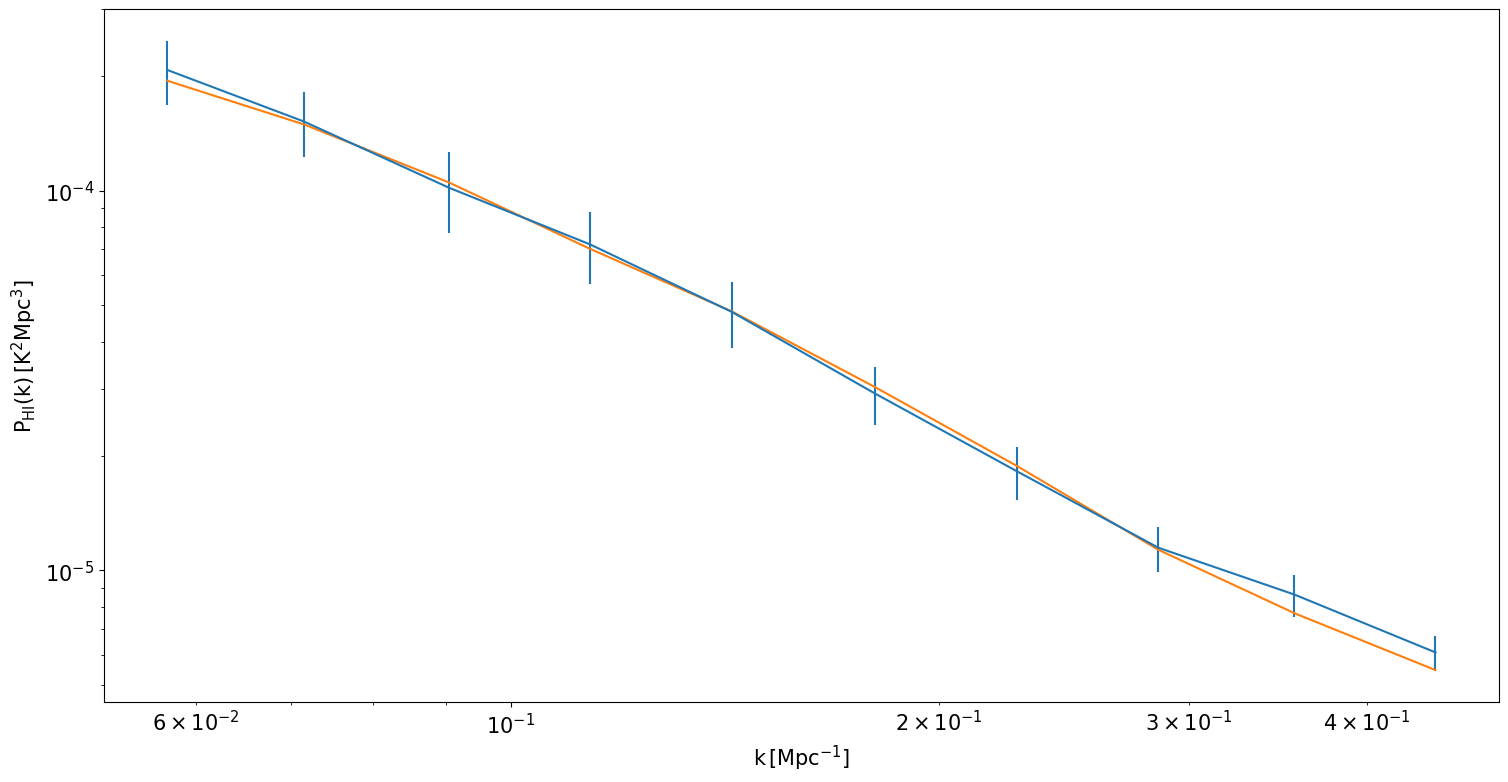

In [74]:
i = 1
plt.rcParams.update({'font.size':15})
plt.errorbar(keff,power_arr.mean(0)[i+3],yerr=power_arr.std(0)[i+3])

plt.plot(keff,power_arr.mean(0)[i])

plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\rm P_{HI}(k)\,[K^2Mpc^3]$')
plt.xlabel(r'$\rm k\,[Mpc^{-1}]$')

Text(0.5, 0, '$\\rm k\\,[Mpc^{-1}]$')

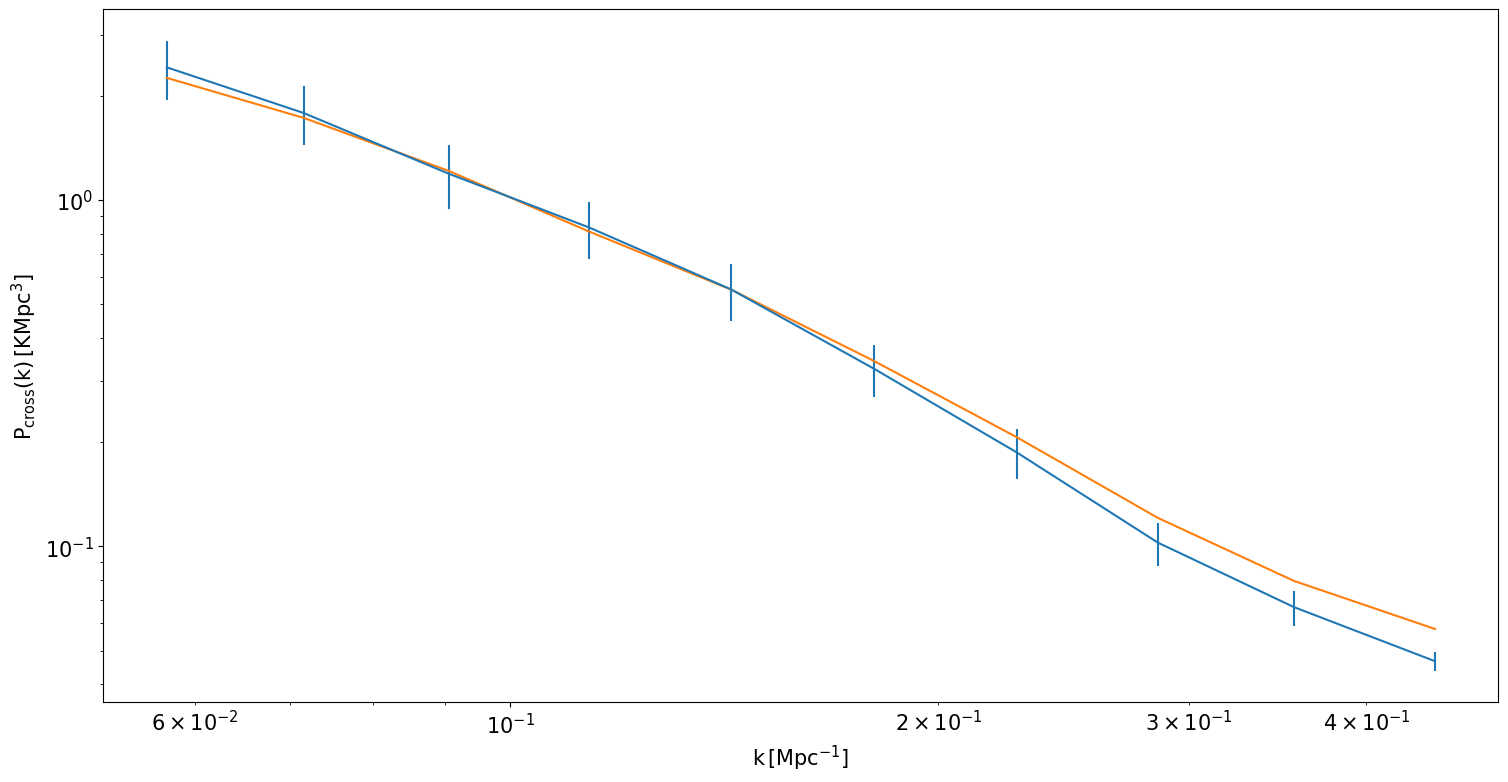

In [75]:
i = 2
plt.rcParams.update({'font.size':15})
plt.errorbar(keff,power_arr.mean(0)[i+3],yerr=power_arr.std(0)[i+3])

plt.plot(keff,power_arr.mean(0)[i])

plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\rm P_{cross}(k)\,[KMpc^3]$')
plt.xlabel(r'$\rm k\,[Mpc^{-1}]$')

You can also visualise the correlation matrices of the signals (illustration only, covariance needs much more than just 10 realizations to converge)

In [76]:
power_cov = power_arr-power_arr.mean(0)[None]
power_cov = (power_cov[:,:,:,None]*power_cov[:,:,None,:]).mean(0)

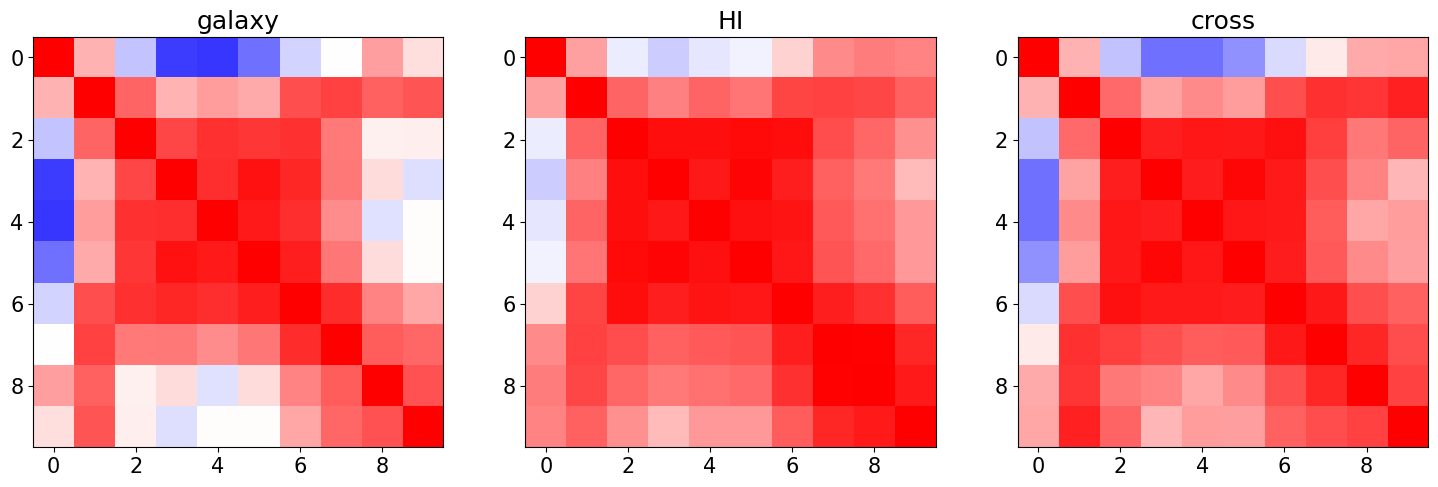

In [77]:
fig,axes= plt.subplots(1,3)
titlearr = ['galaxy','HI','cross']
for i in range(3):
    cov_arr = power_cov[i+3]
    cov_diag = np.sqrt((np.diagonal(cov_arr)))
    cov_arr /= cov_diag[:,None] * cov_diag[None,:]
    axes[i].imshow(cov_arr,vmin=0,vmax=1,cmap='bwr')
    axes[i].set_title(titlearr[i])

Note that, the pixel resolution in the default setting is:

In [78]:
mock.pix_resol_in_mpc, mock.pix_resol # in Mpc and in deg

(8.634079268761422, 0.3)

Which corresponds to the scale of:

In [79]:
np.pi/mock.pix_resol_in_mpc

0.36385960283643093

Scales close to the map resolution will inevitably be harder to measure. Note that in reality, MeerKAT has a ~1 deg beam. We can add in the beam effects quite easily (see separate tutorials on beam (TODO) for more details):

In [80]:
from meer21cm.telescope import dish_beam_sigma

In [81]:
D_dish = 13.5 #in m
mock.sigma_beam_ch = dish_beam_sigma(D_dish,mock.nu)

The default beam is a simple Gaussian:

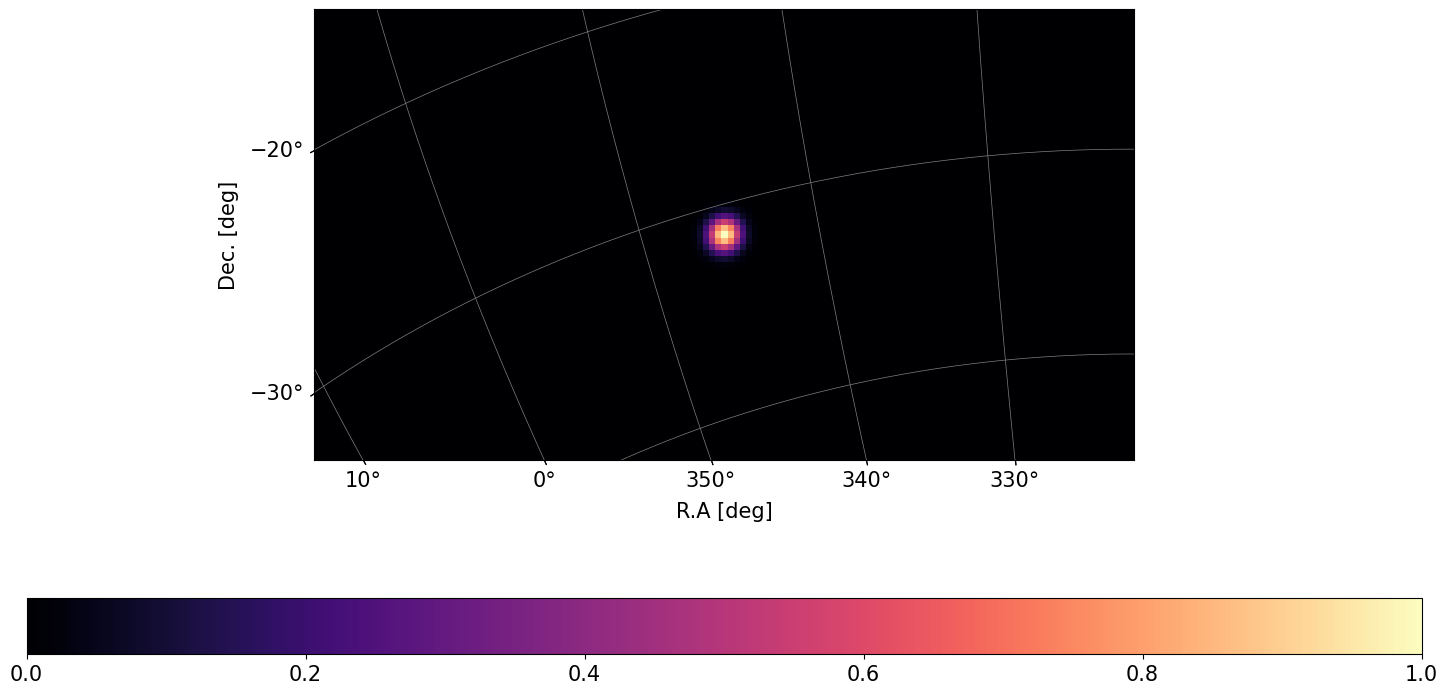

In [82]:
plot_map(mock.beam_image,mock.wproj)

You can convolve this beam with the mock signal map:

In [83]:
mock.convolve_data(mock.beam_image)

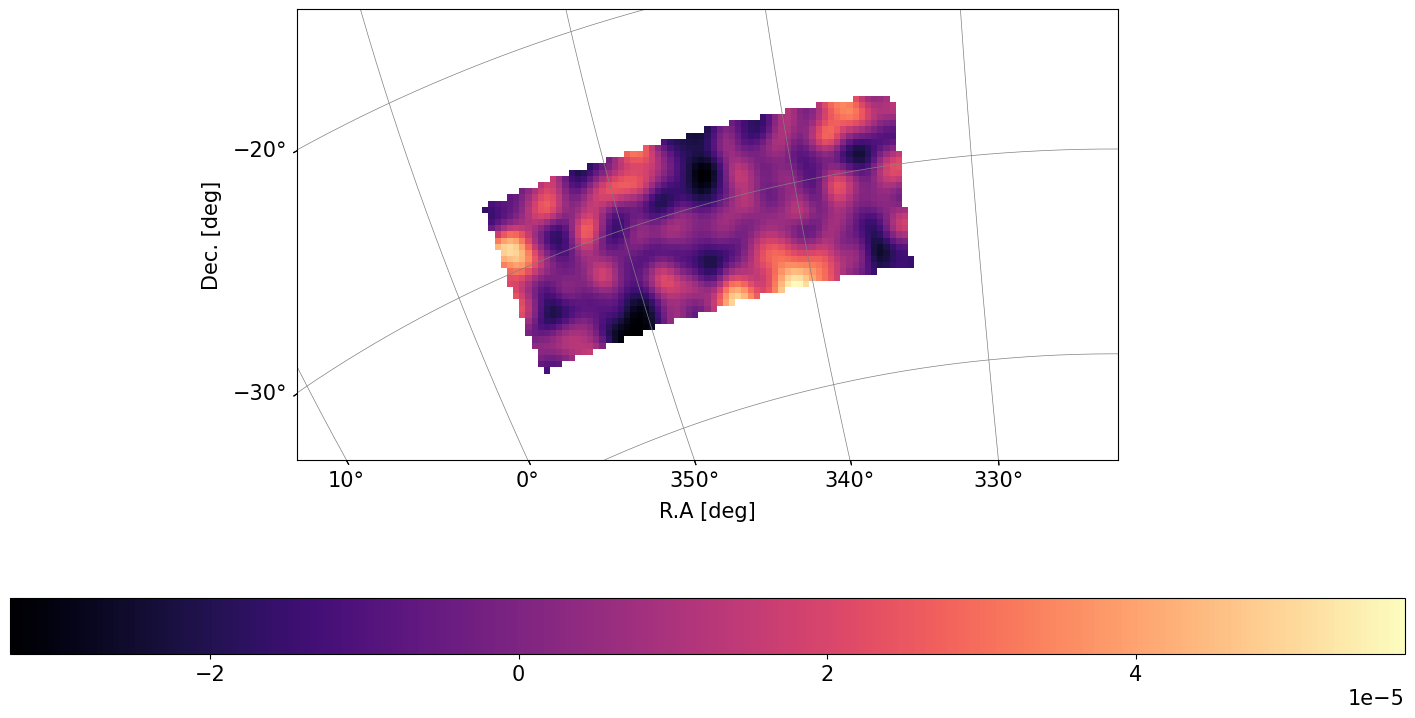

In [84]:
plot_map(mock.data,mock.wproj,W=mock.W_HI)


Then redo the gridding and power spectrum estimation. The model power spectrum will also be automatically updated to include the beam attenuation effects. Let's redo the realizations to see the differences:

In [88]:
def run_one_realization_beam(seed=None):
    mock = MockSimulation(
        ra_range=ra_range,dec_range=dec_range,mean_amp_1='average_hi_temp',
        tracer_bias_2=1.0,tracer_bias_1=1.0,
        downres_factor_radial=0.5,downres_factor_transverse=0.5,
        k1dbins = k1dedges,num_discrete_source=30000,compensate=False,
        seed=seed,
    )
    mock.data = mock.grid_field_to_sky_map(mock.mock_tracer_field_1)[0]
    mock.propagate_mock_tracer_to_gal_cat()
    mock.sigma_beam_ch = dish_beam_sigma(D_dish,mock.nu)
    mock.convolve_data(mock.beam_image)
    mock.downres_factor_radial=1.5
    mock.downres_factor_transverse=1.2
    mock.grid_data_to_field()
    mock.grid_gal_to_field()
    mock.sampling_resol = np.array([
        mock.pix_resol_in_mpc,
        mock.pix_resol_in_mpc,
        mock.los_resol_in_mpc,
    ])
    mock.compensate = True
    mock.include_sky_sampling = [True, False]
    # get model
    pmod_1d_gg,_,_ = mock.get_1d_power(
        'auto_power_tracer_2_model'
    )
    pmod_1d_hi,_,_ = mock.get_1d_power(
        'auto_power_tracer_1_model'
    )
    pmod_1d_cross,_,_ = mock.get_1d_power(
        'cross_power_tracer_model'
    )
    # get data
    pdata_1d_gg,keff,nmodes = mock.get_1d_power(
        'auto_power_3d_2',
    )
    pdata_1d_hi,keff_hi,nmodes_hi = mock.get_1d_power(
        'auto_power_3d_1',
    )
    pdata_1d_c,keff_c,nmodes_c = mock.get_1d_power(
        'cross_power_3d',
    )
    return [[pmod_1d_gg,pmod_1d_hi,pmod_1d_cross,pdata_1d_gg,pdata_1d_hi,pdata_1d_c],]
    
    

In [89]:
%%capture
power_arr_beam = []
s_t = time.time()
for i in range(10):
    power_arr_beam += run_one_realization_beam(i)
t_used = time.time()-s_t

In [90]:
print('Time used in seconds: ',time.time()-s_t)

Time used in seconds:  1588.2425577640533


In [91]:
power_arr_beam = np.array(power_arr_beam)

Galaxy is not affected by beam:

Text(0.5, 0, '$\\rm k\\,[Mpc^{-1}]$')

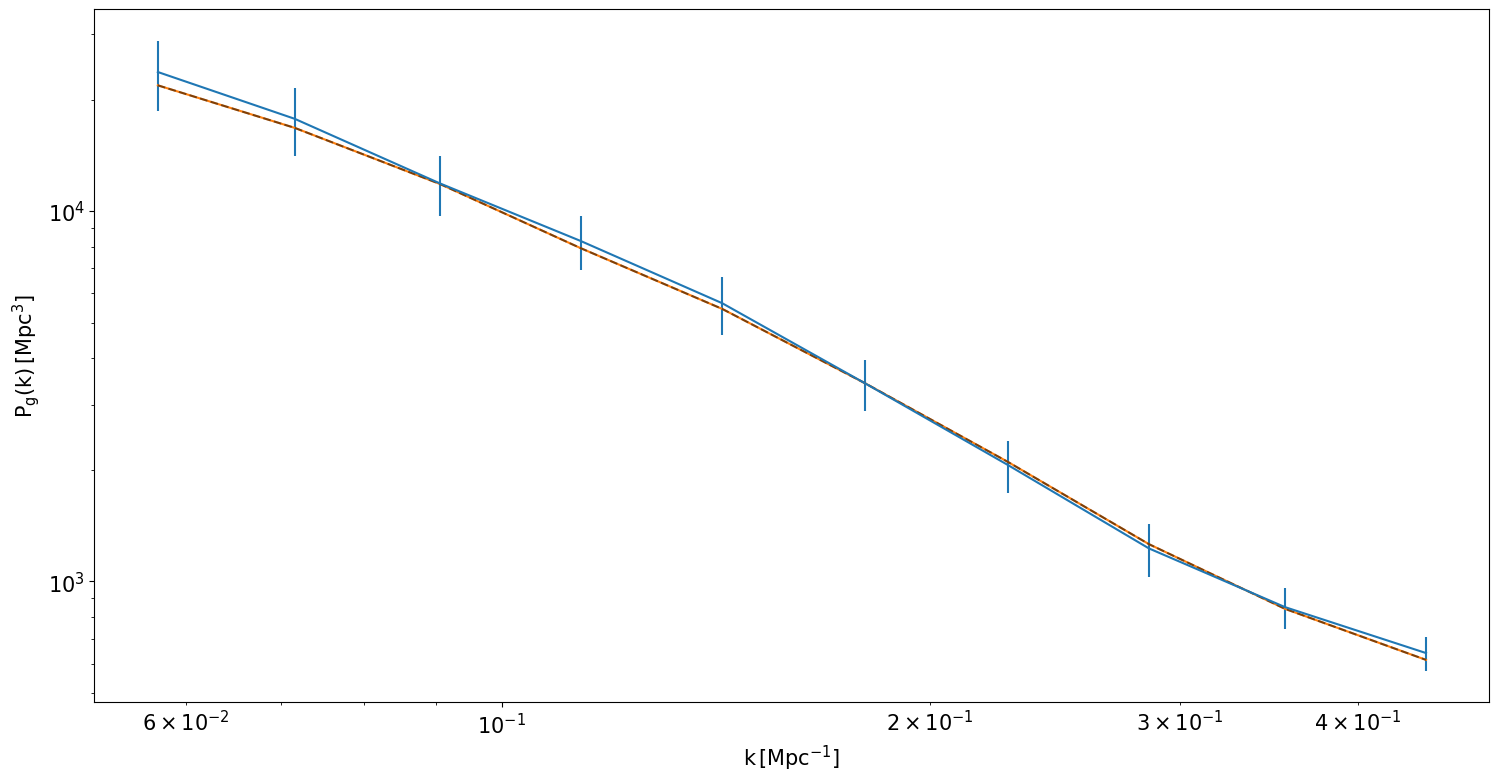

In [92]:
i = 0
plt.rcParams.update({'font.size':15})
plt.errorbar(keff,power_arr_beam.mean(0)[i+3]-psn_1d_gg,yerr=power_arr_beam.std(0)[i+3])

plt.plot(keff,power_arr_beam.mean(0)[i])
plt.plot(keff,power_arr.mean(0)[i],color='black',ls='--',alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\rm P_g(k)\,[Mpc^3]$')
plt.xlabel(r'$\rm k\,[Mpc^{-1}]$')

HI is:

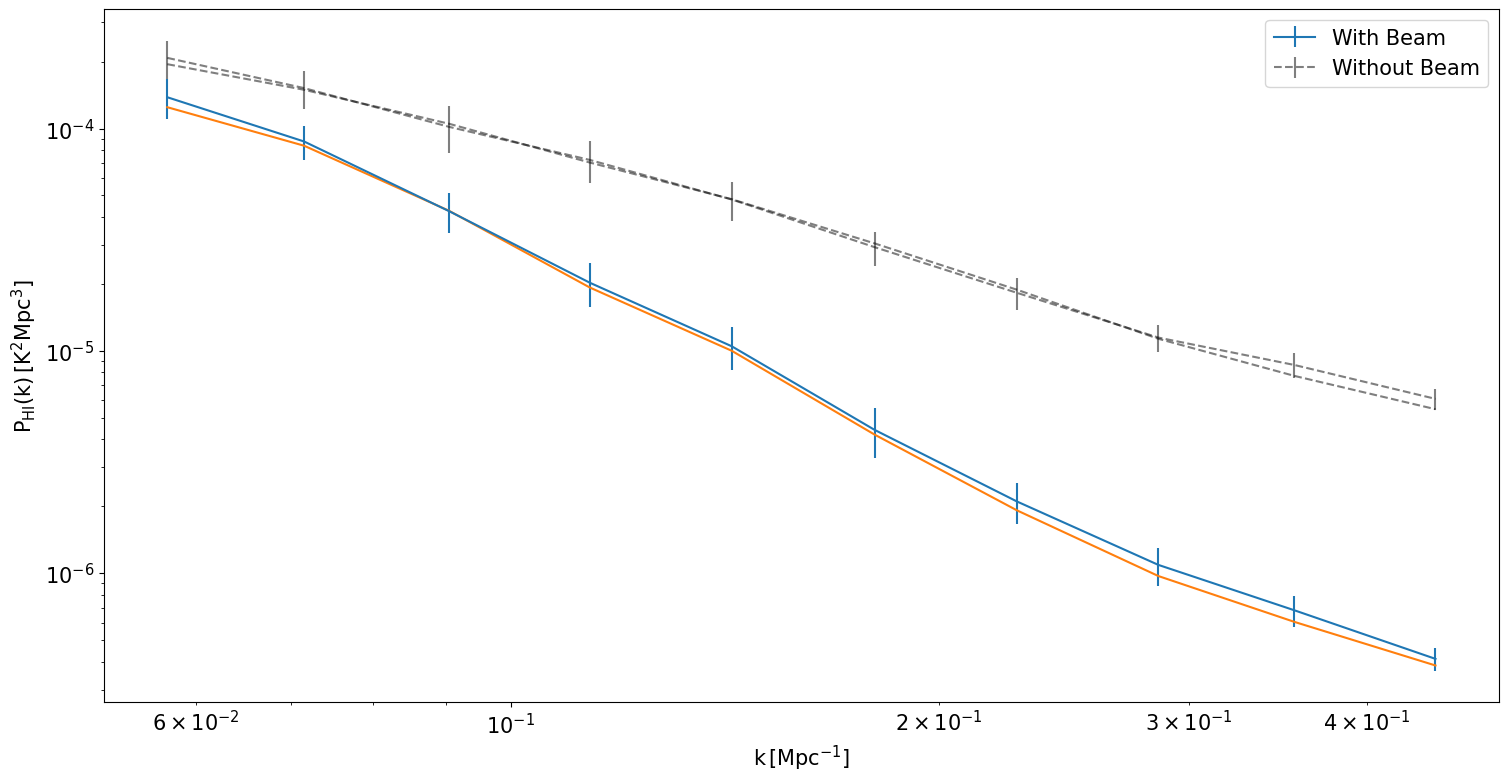

In [93]:
i = 1
plt.rcParams.update({'font.size':15})
plt.errorbar(keff,power_arr_beam.mean(0)[i+3],yerr=power_arr_beam.std(0)[i+3],label='With Beam')
plt.errorbar(keff,power_arr.mean(0)[i+3],yerr=power_arr.std(0)[i+3],label='Without Beam',
             color='black',ls='--',alpha=0.5)

plt.plot(keff,power_arr_beam.mean(0)[i])
plt.plot(keff,power_arr.mean(0)[i],color='black',ls='--',alpha=0.5)

plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\rm P_{HI}(k)\,[K^2Mpc^3]$')
plt.xlabel(r'$\rm k\,[Mpc^{-1}]$')
plt.legend()

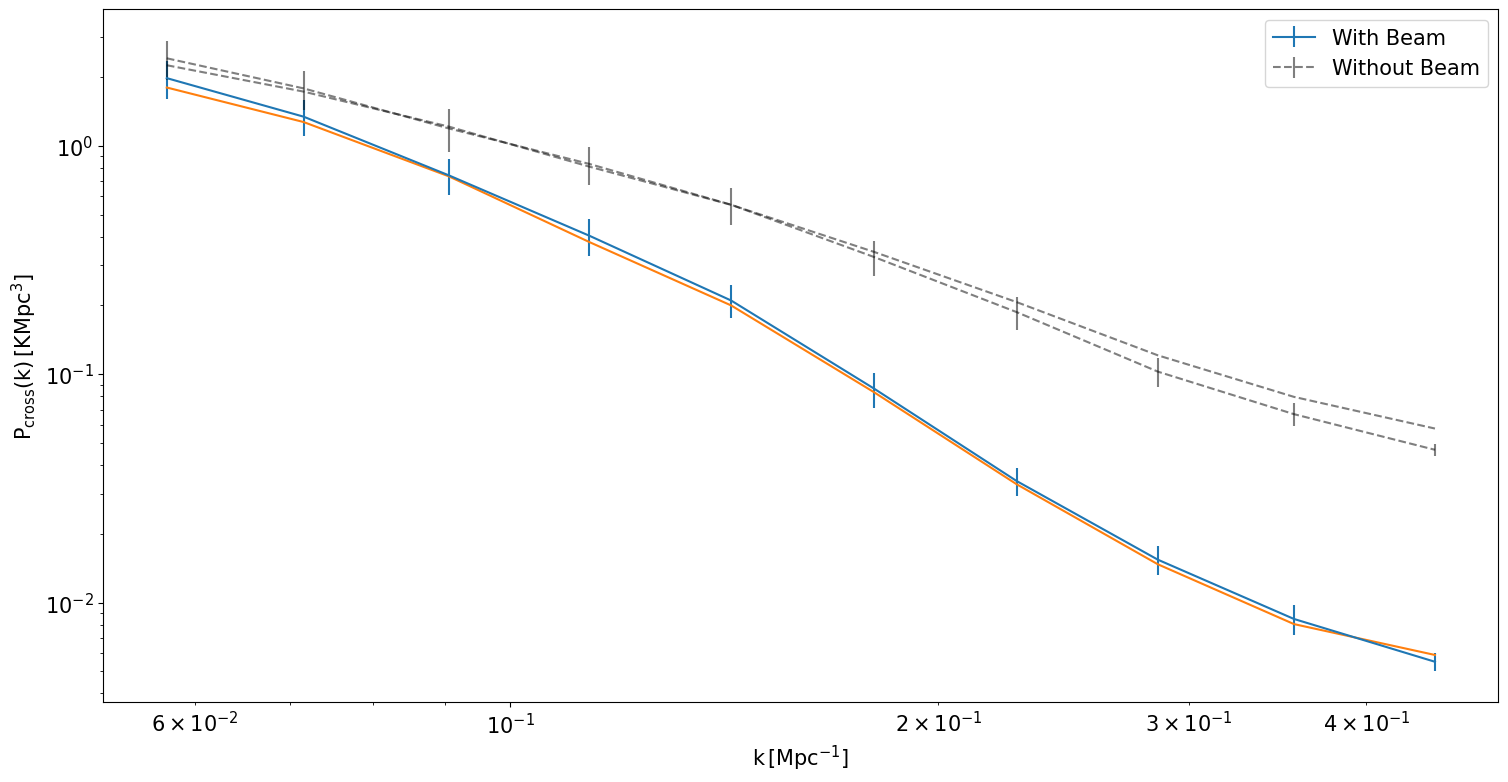

In [94]:
i = 2
plt.rcParams.update({'font.size':15})
plt.errorbar(keff,power_arr_beam.mean(0)[i+3],yerr=power_arr_beam.std(0)[i+3],label='With Beam')
plt.errorbar(keff,power_arr.mean(0)[i+3],yerr=power_arr.std(0)[i+3],label='Without Beam',
             color='black',ls='--',alpha=0.5)

plt.plot(keff,power_arr_beam.mean(0)[i])
plt.plot(keff,power_arr.mean(0)[i],color='black',ls='--',alpha=0.5)

plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\rm P_{cross}(k)\,[KMpc^3]$')
plt.xlabel(r'$\rm k\,[Mpc^{-1}]$')
plt.legend()